In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import glob
import matplotlib.pyplot as plt

In [16]:
# LOAD AND PREPROCESS THE DATA
# Load the dataset
file_paths = glob.glob('Data/CSV/*.csv')

# Initialize an empty list to store DataFrames
dfs = []

# Iterate through the list of file paths and read each CSV into a DataFrame
for file_path in file_paths:
    df = pd.read_csv(file_path, sep=';')
    dfs.append(df)

# Concatenate all the DataFrames into one
concatenated_df = pd.concat(dfs, ignore_index=True) 

In [17]:
# PREPROCESSING
df_cleaned = concatenated_df.dropna()

In [18]:
def augment_parallax_errors(df, anomaly_rate, error_factor):
    """
    Augments the parallax values with errors to simulate anomalies.
    
    Parameters:
    df (DataFrame): A DataFrame containing the original Gaia data.
    anomaly_rate (float): The fraction of total objects that should be anomalous.
    error_factor (float): A factor that determines the magnitude of the error introduced.

    Returns:
    DataFrame: A DataFrame with the augmented parallax data.
    """
    # Make a copy of the DataFrame to avoid altering the original data
    augmented_df = df.copy()
    
    # Calculate the number of objects to alter based on the anomaly rate
    num_anomalies = int(len(df) * anomaly_rate)
    
    # Select random indices for introducing anomalies
    anomaly_indices = np.random.choice(df.index, size=num_anomalies, replace=False)
    
    # Introduce errors in the parallax values
    # The error can be a random value that depends on the error_factor and the current parallax value
    augmented_df.loc[anomaly_indices, 'parallax'] += error_factor * np.random.randn(num_anomalies) * augmented_df.loc[anomaly_indices, 'parallax']
    
    # Mark the augmented objects as anomalous
    augmented_df.loc[anomaly_indices, 'correct/anomalous'] = 0  # Assuming 0 represents anomalous in your dataset
    
    return augmented_df

In [19]:
augmented_df = augment_parallax_errors(df_cleaned, anomaly_rate=0.1, error_factor=100.0)

In [20]:
# Function to print class distribution
def print_class_distribution(y_data):
    count_class_0 = sum(y_data == 0)
    count_class_1 = sum(y_data == 1)
    total = len(y_data)
    print("Class 0: {:.2f}%, Class 1: {:.2f}%".format((count_class_0 / total) * 100, (count_class_1 / total) * 100))

In [21]:
# Splitting the augmented dataset into initial training set and unlabeled pool
initial_train_size = 50
# Randomly sample initial training data
initial_train_indices = np.random.choice(a=augmented_df.index, size=initial_train_size, replace=False)
X_initial = augmented_df.drop('correct/anomalous', axis=1).loc[initial_train_indices]
y_initial = augmented_df['correct/anomalous'].loc[initial_train_indices]
# Create the pool by excluding the initial training data
X_pool = augmented_df.drop('correct/anomalous', axis=1).drop(initial_train_indices)
y_pool = augmented_df['correct/anomalous'].drop(initial_train_indices)

In [22]:
# Initialize and train the Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(X_initial, y_initial)

RandomForestClassifier()

In [23]:
# UNCERTAINTY SAMPLING
# Active learning loop (acquisition function)
total_data_points = 6000
augmented_df = augment_parallax_errors(df_cleaned, anomaly_rate=0.1, error_factor=100.0)
X_pool_initial = augmented_df.drop('correct/anomalous', axis=1)
y_pool_initial = augmented_df['correct/anomalous']

# Dictionary to store the balance of the training set for each combination
balance_results = {}
epoch_balance_results = {}

for i in [1, 50, 100, 150, 250, 500]:
    if total_data_points % i == 0:
        X_pool = X_pool_initial.copy()
        y_pool = y_pool_initial.copy()
        X_train = X_initial.copy()
        y_train = y_initial.copy()

        epoch_balances = {}
        
        for epoch in range(i):
            # Randomly select data points
            random_indices = np.random.choice(X_pool.index, size=int(total_data_points/i), replace=False)
            random_points = X_pool.loc[random_indices]
            random_labels = y_pool.loc[random_indices]

            # Add these points to the training set
            X_train_extended = pd.concat([X_train, random_points])
            y_train_extended = pd.concat([y_train, random_labels])

            # Retrain the model on the extended training set
            rfc.fit(X_train_extended, y_train_extended)

            # Calculate balance score at this epoch
            class_distribution = y_train_extended.value_counts(normalize=True)
            balance = abs(class_distribution[0] - class_distribution[1])
            epoch_balances[epoch + 1] = balance  # Store balance for this epoch

            # Update the pool by excluding the selected points
            X_pool = X_pool.drop(random_indices)
            y_pool = y_pool.drop(random_indices)

        # Evaluate the balance of the training set
        class_distribution = y_train_extended.value_counts(normalize=True)
        print('epochs', i, 'nr of datapoints', total_data_points/i)
        print_class_distribution(y_train_extended)
        # print("epoch_balances", epoch_balances)

        # Store the epoch balances for each combination
        epoch_balance_results[(i, int(total_data_points / i))] = epoch_balances

        # Calculate the balance score
        balance = abs(class_distribution[0] - class_distribution[1])
        balance_results[(i, int(total_data_points/i))] = balance

# Analyze the balance results to find the best combination
best_combination = min(balance_results, key=balance_results.get)
print("Best combination (Epochs, Data points per epoch):", best_combination)
print("Balance score:", balance_results[best_combination]) #  lower balance score indicates a more balanced class distribution.



epochs 1 nr of datapoints 6000.0
Class 0: 10.02%, Class 1: 89.98%
epochs 50 nr of datapoints 120.0
Class 0: 9.41%, Class 1: 90.59%
epochs 100 nr of datapoints 60.0
Class 0: 10.91%, Class 1: 89.09%
epochs 150 nr of datapoints 40.0
Class 0: 10.00%, Class 1: 90.00%
epochs 250 nr of datapoints 24.0
Class 0: 9.46%, Class 1: 90.54%
epochs 500 nr of datapoints 12.0
Class 0: 9.68%, Class 1: 90.32%
Best combination (Epochs, Data points per epoch): (100, 60)
Balance score: 0.7818181818181817


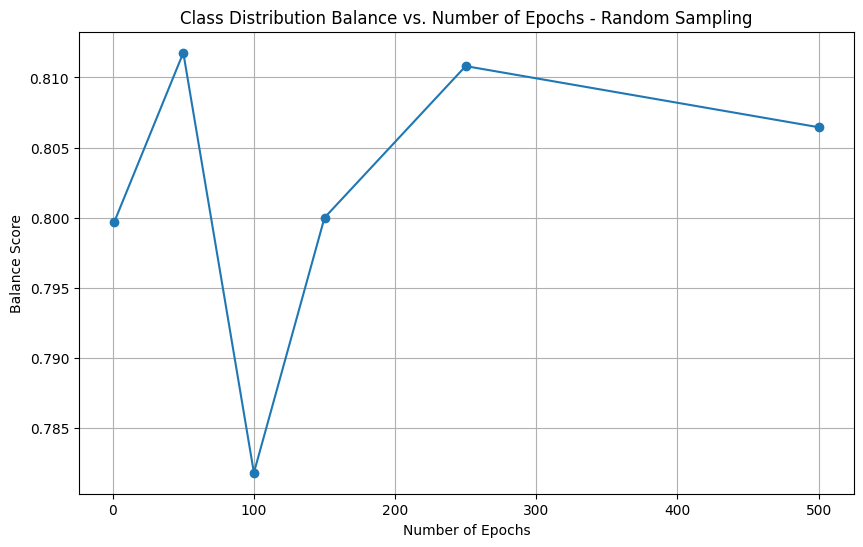

In [29]:
# make a graph that shows which combination of epochs and nr of datapoints gives the best result
# Extracting epochs and balance scores from the balance_results dictionary
epochs = [key[0] for key in balance_results.keys()]
balance_scores = [balance_results[key] for key in balance_results.keys()]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, balance_scores, marker='o')
plt.xlabel('Number of Epochs')
plt.ylabel('Balance Score')
plt.title('Class Distribution Balance vs. Number of Epochs - Random Sampling')
plt.grid(True)
plt.show()

/var/folders/7n/q27dsfc979d7tc093k556wj40000gn/T/ipykernel_1398/3722299401.py:18: RankWarning: Polyfit may be poorly conditioned
  fitted_curve = np.polyfit(x_values, y_values, degree)


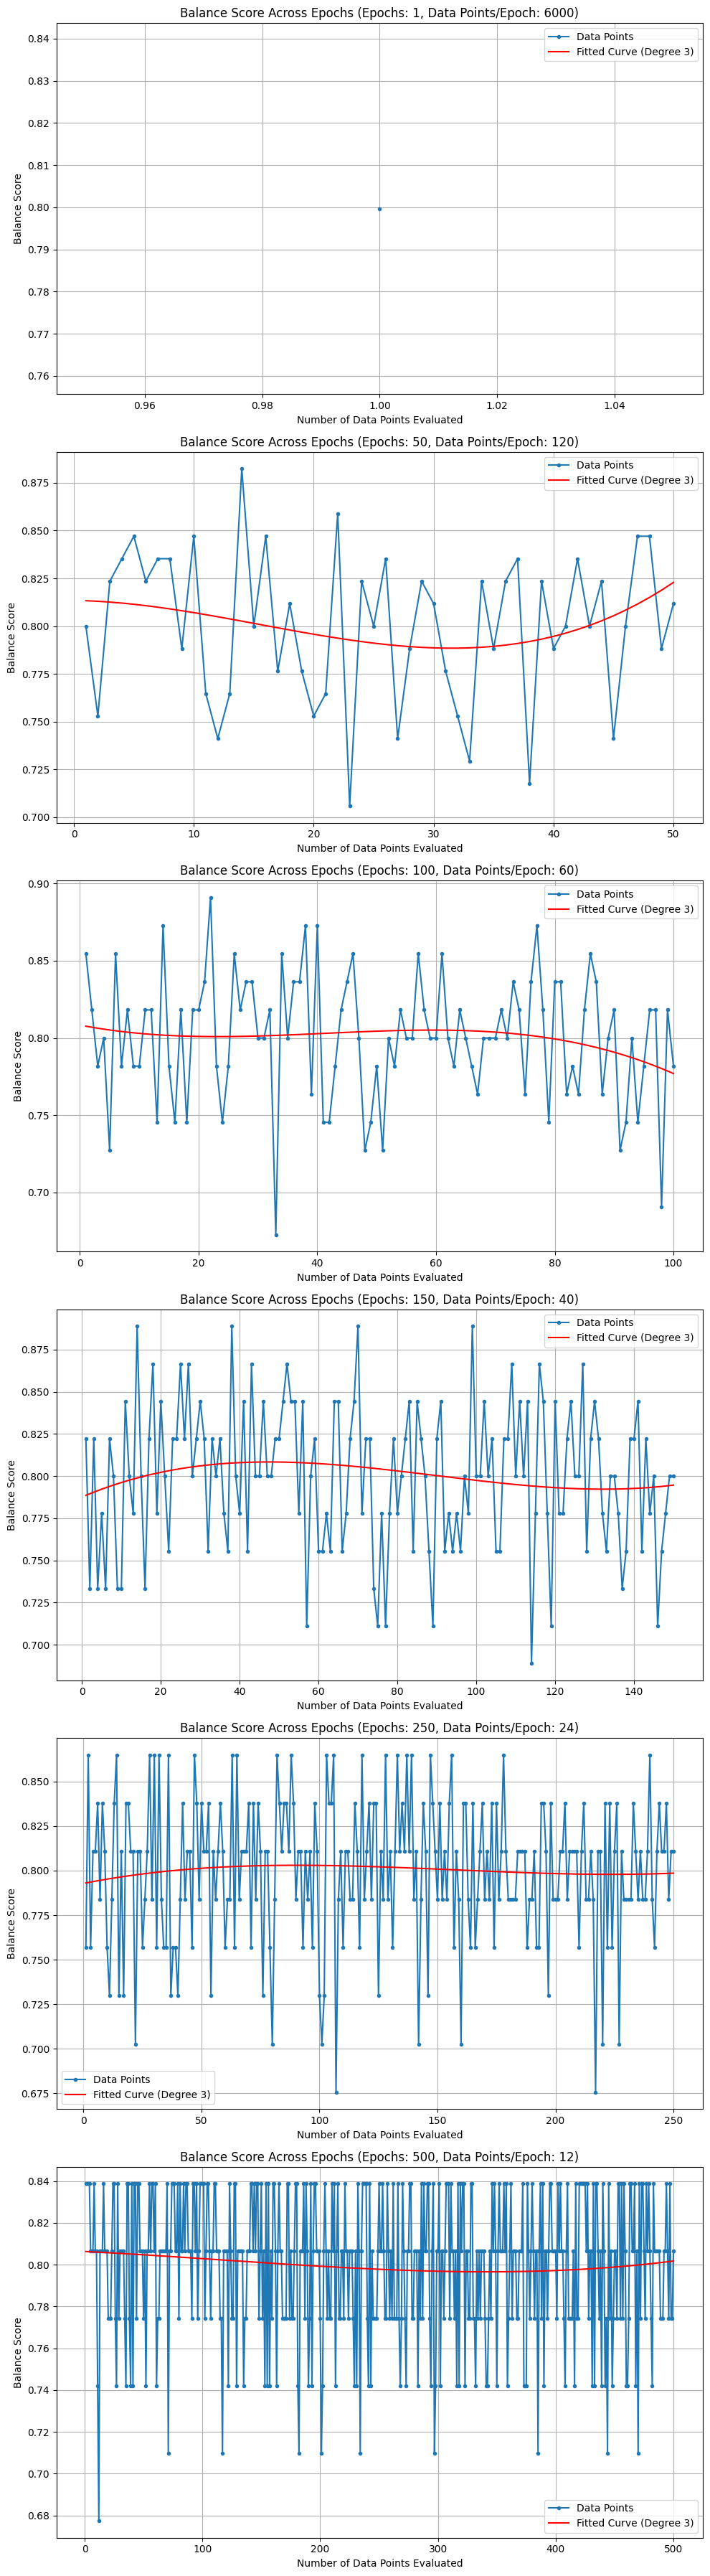

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Create a single figure to contain all subplots
fig, axs = plt.subplots(len(epoch_balance_results), figsize=(10, 6 * len(epoch_balance_results)))

# Iterate over each combination and subplot
for i, (combination, epoch_balances) in enumerate(epoch_balance_results.items()):
    epochs, data_points_per_epoch = combination
    total_data_points = epochs * data_points_per_epoch

    # Lists to store x (number of data points evaluated) and y (balance score) values
    x_values = list(epoch_balances.keys())
    y_values = list(epoch_balances.values())

    # Fit a polynomial curve (you can adjust the degree)
    degree = 3  # Adjust the degree of the polynomial as needed
    fitted_curve = np.polyfit(x_values, y_values, degree)
    fitted_y_values = np.polyval(fitted_curve, x_values)

    # Plotting in the i-th subplot
    axs[i].plot(x_values, y_values, marker='o', markersize=3, label='Data Points')
    axs[i].plot(x_values, fitted_y_values, label=f'Fitted Curve (Degree {degree})', color='red')

    axs[i].set_xlabel('Number of Data Points Evaluated')
    axs[i].set_ylabel('Balance Score')
    axs[i].set_title(f'Balance Score Across Epochs (Epochs: {epochs}, Data Points/Epoch: {data_points_per_epoch})')
    axs[i].grid(True)
    axs[i].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()


In [26]:
# After the active learning loop completes and you have the best_combination
# best_combination = min(balance_results, key=balance_results.get)

# Extract the best combination values
print("Best combination (Epochs, Data points per epoch):", best_combination)
best_epochs, best_data_points_per_epoch = best_combination

# Create a new RandomForestClassifier with the best hyperparameters
best_rfc = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust hyperparameters

# Combine X_pool_initial and X_train_extended
X_combined = pd.concat([X_pool_initial, X_train_extended])
y_combined = pd.concat([y_pool_initial, y_train_extended])

# Train the best classifier on the entire dataset with the best combination
best_rfc.fit(X_combined, y_combined)

# Now, best_rfc is your final Random Forest classifier trained with the best combination
# You can use it to make predictions on the test set

Best combination (Epochs, Data points per epoch): (100, 60)


RandomForestClassifier(random_state=42)

In [27]:
# Loading a separate test set from another CSV file
test_df = pd.read_csv('Data/Capella5arcmin.csv', sep=';')
length_df = len(test_df)
print("Length of the dataset: ", length_df)

df_cleaned = test_df.dropna()
length_df_cleaned = len(df_cleaned)
print("Length of the cleaned dataset: ", length_df_cleaned)

column_names = df_cleaned.columns
print(column_names)

augmented_test_df = augment_parallax_errors(df_cleaned, anomaly_rate=0.5, error_factor=100.0)
X_test = augmented_test_df.drop('correct/anomalous', axis=1)
y_test = augmented_test_df['correct/anomalous']

Length of the dataset:  921
Length of the cleaned dataset:  741
Index(['correct/anomalous', 'ra', 'dec', 'parallax', 'pmra', 'pmdec',
       'astrometric_excess_noise', 'ruwe', 'phot_g_mean_mag',
       'phot_bp_rp_excess_factor', 'bp_rp'],
      dtype='object')


In [28]:
# Evaluate the model on the new test set
y_pred = rfc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5060728744939271

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.01      0.02       370
           1       0.50      1.00      0.67       371

    accuracy                           0.51       741
   macro avg       0.75      0.51      0.35       741
weighted avg       0.75      0.51      0.35       741

